The objective of this project is to predict house prices based on the Ames Housing dataset. We aim to build a model that minimizes the Root Mean Squared Error (RMSE) to accurately estimate property value.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error)

## About dataset. Ames Housing Dataset

 It contains various features and attributes of residential homes in Ames, Iowa, USA. The dataset is often used for regression tasks, particularly for predicting housing prices.

In [2]:
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
df = housing.data.copy(deep=True)
df = df.astype({'Id': int})
df = df.set_index('Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
X = housing.data
y = housing.target

## Let's look at the data

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

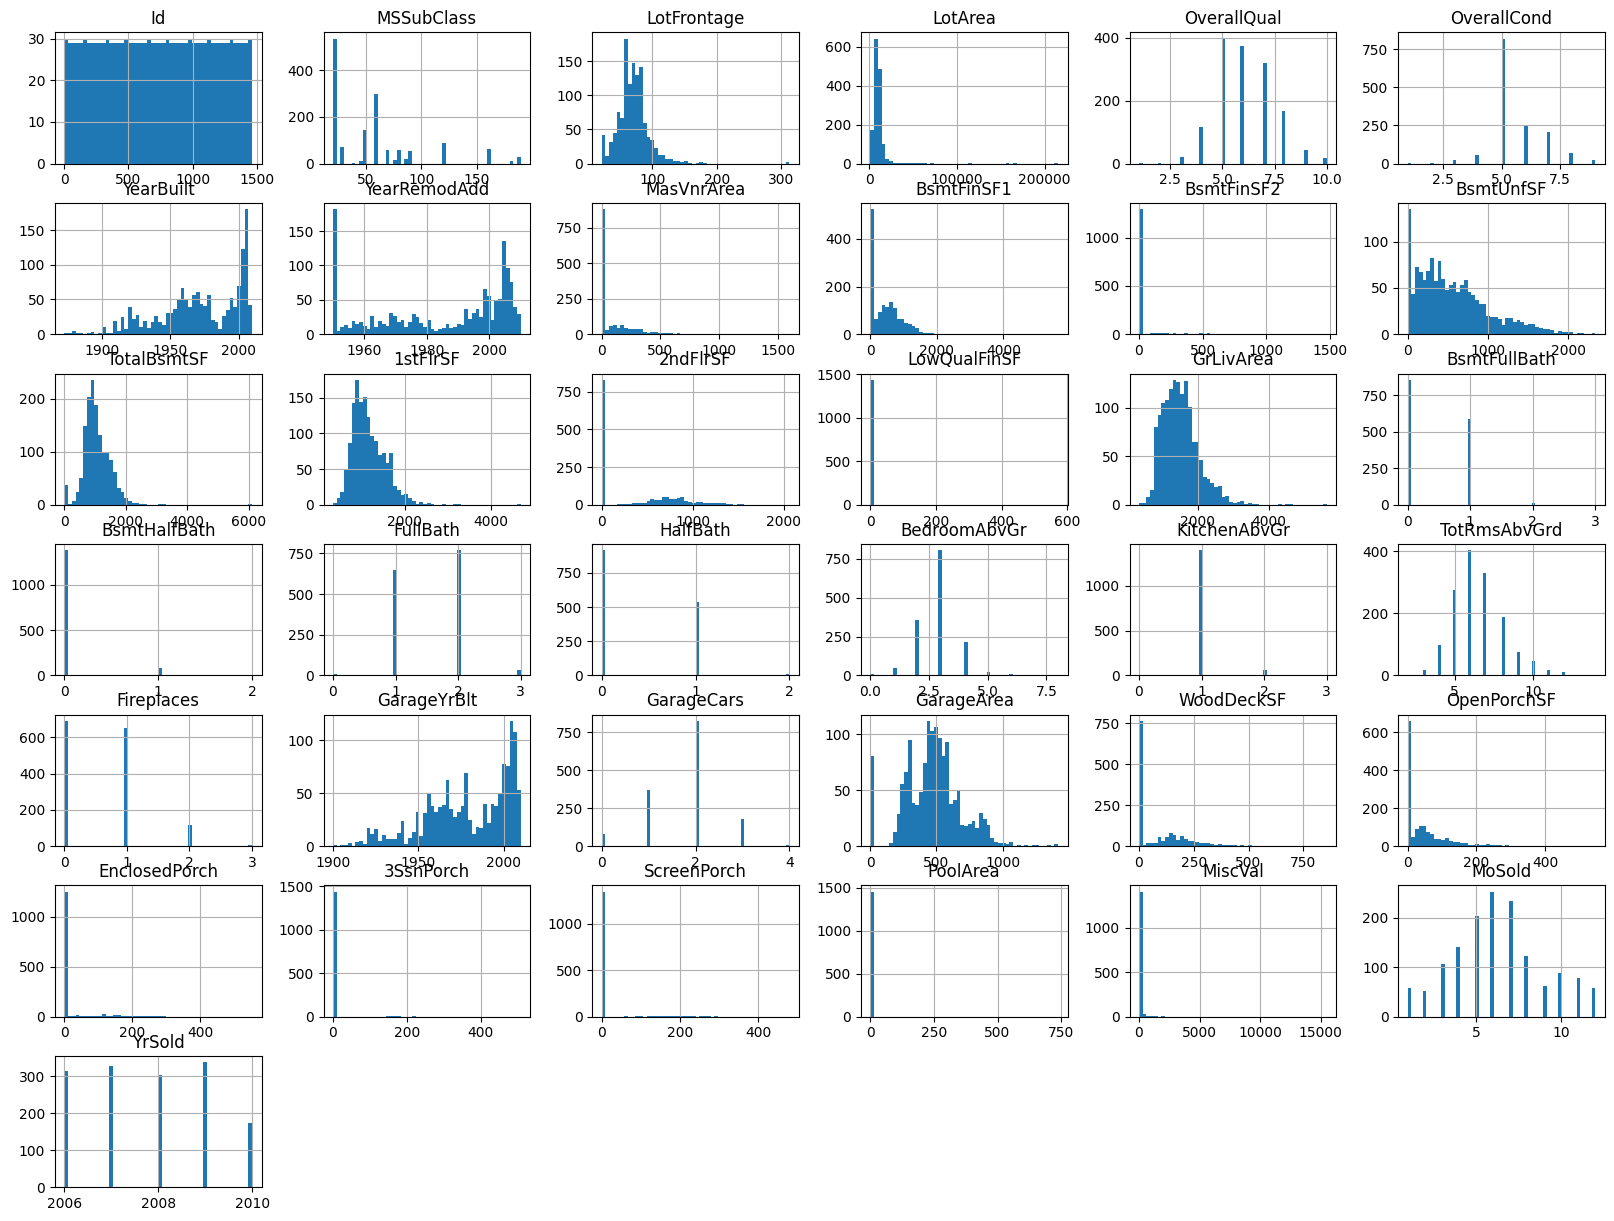

In [5]:
X.hist(bins=50, figsize=(20,15))

I selected the parameters that I believe will have the strongest influence on the target variable. Next, I construct a graph to see if I can identify any patterns.

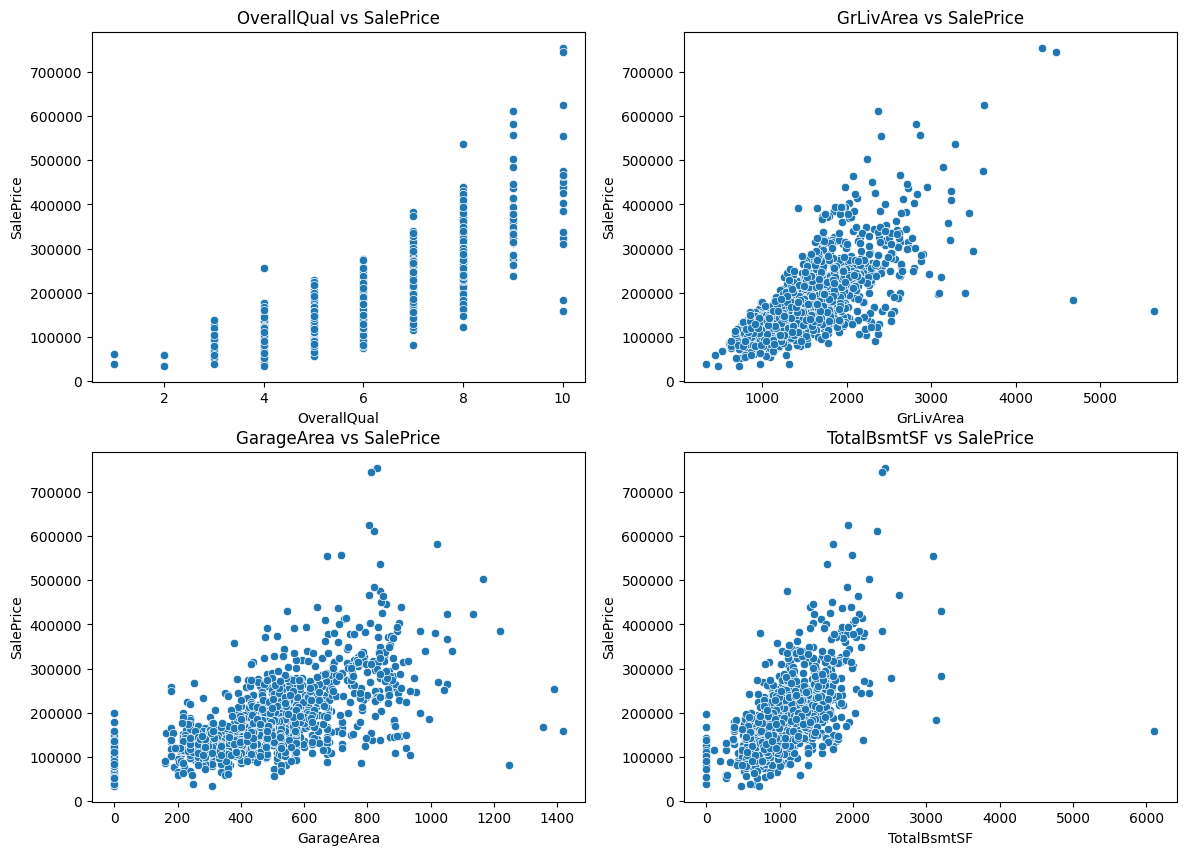

In [6]:
imp_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']

plt.figure(figsize=(14, 10))

df_copy = X.copy()
df_copy['SalePrice'] = y

for i, col in enumerate(imp_cols):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(data=df_copy, x=col, y='SalePrice')
    plt.title(f'{col} vs SalePrice')
    plt.ylabel('SalePrice')
    plt.xlabel(col)

plt.show()

As each of the selected variables increases, the price of the house also increases.

# Preprocessing

I also saw several outliers that will have a very negative impact on linear regression models (according to my experiments, including these outliers, the RMSE increases by more than 5000-8000).

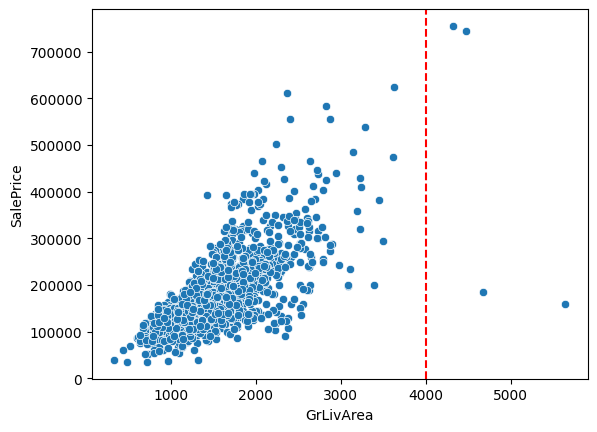

In [7]:
sns.scatterplot(x=X['GrLivArea'], y=y)
plt.axvline(x=4000, color='r', linestyle='--')
plt.show()

In [8]:
outliers = X[X['GrLivArea']>4000].index

We remove outliers and proceed to data preprocessing

In [9]:
X = X.drop(outliers)
y = y.drop(outliers)

We divide the data into three pipelines. The first is for numerical attributes, and the second and third are for categorical attributes. We divide categorical features into two types so that SimpleImputer uses different strategies for filling in missing data. Cat_none_attribs contains all columns in which NaN means absence, and cat_freq_attribs contains all columns in which there may not be enough data and they need to be filled in with the most frequent values already present in the column.

In [10]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_none_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

cat_freq_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


num_attribs = X.select_dtypes(["int64", "float64"]).columns
cat_none_attribs = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]
cat_freq_attribs = [col for col in X.select_dtypes(["object"]).columns if col not in cat_none_attribs]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat_none', cat_none_pipeline, cat_none_attribs),
    ('cat_freq', cat_freq_pipeline, cat_freq_attribs)
])

full_pipeline.set_output(transform="pandas")
X_prep = full_pipeline.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = 0.2, random_state = 42)

Let's see how OneHotEncoder worked (a separate column was created for each category in the column and filled with ones and zeros)

In [12]:
X_train.filter(like='SaleCondition').head()

,cat_freq__SaleCondition_Abnorml,cat_freq__SaleCondition_AdjLand,cat_freq__SaleCondition_Alloca,cat_freq__SaleCondition_Family,cat_freq__SaleCondition_Normal,cat_freq__SaleCondition_Partial
254,0.0,0.0,0.0,0.0,1.0,0.0
1065,0.0,0.0,0.0,0.0,1.0,0.0
637,0.0,0.0,0.0,0.0,1.0,0.0
1292,0.0,0.0,0.0,0.0,1.0,0.0
514,0.0,0.0,0.0,0.0,1.0,0.0


# Modeling
We will evaluate multiple regression algorithms, starting from a baseline Linear Regression and moving to regularized models (Ridge, Lasso, ElasticNet) and Support Vector Regression (SVR). The primary evaluation metric is RMSE (Root Mean Squared Error), as it penalizes large errors more heavily.

## Model training and evaluation

I will create a function for convenient and fast model training and also for evaluating it using four different metrics. I will save the result in a list so that I can compare all models at the end and sort them.

In [13]:
result = []

In [14]:
def train_evaluate(model, model_name, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = mean_squared_error(y_test, y_pred) ** 0.5
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  print("Result for", model_name)
  print("RMSE: ", round(rmse, 2))
  print("R2: ", round(r2, 2))
  print("MAE: ", round(mae, 2))
  print("MAPE: ", round(mape, 2))

  model_res = {
      "Model": model_name,
      "RMSE": round(rmse, 2),
      "R2": round(r2, 2),
      "MAE": round(mae, 2),
      "MAPE": round(mape, 2),
  }

  if model_res not in result:
    result.append(model_res)

  return model

## Gradient descent

In [15]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.001, random_state=42)
sgd_reg = train_evaluate(sgd_reg, "SGDRegressor", X_train, y_train, X_test, y_test)

Result for SGDRegressor
RMSE:  22093.21
R2:  0.91
MAE:  15945.99
MAPE:  0.1


In [16]:
result

[{'Model': 'SGDRegressor',
  'RMSE': 22093.21,
  'R2': 0.91,
  'MAE': 15945.99,
  'MAPE': 0.1}]

I use GridSearchCV to find the best hyperparameters for gradient descent.

In [17]:
param_grid = [
    {'max_iter': [500, 1000, 2000],
     'eta0': [0.005, 0.001, 0.0005, 0.0001],
     'tol': [1e-3],
     'random_state': [42]}
]
sgd_reg_best = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
sgd_reg_best.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=SGDRegressor(eta0=0.001, penalty=None, random_state=42),
             n_jobs=-1,
             param_grid=[{'eta0': [0.005, 0.001, 0.0005, 0.0001],
                          'max_iter': [500, 1000, 2000], 'random_state': [42],
                          'tol': [0.001]}],
             scoring='roc_auc', verbose=1)

In [18]:
sgd_reg_after_gridsearch = SGDRegressor(max_iter=500, tol=1e-3, penalty=None, eta0=0.005, random_state=42)
sgd_reg_after_gridsearch = train_evaluate(sgd_reg_after_gridsearch, "SGDRegressor after GridSearch", X_train, y_train, X_test, y_test)

Result for SGDRegressor after GridSearch
RMSE:  22056.91
R2:  0.91
MAE:  15940.01
MAPE:  0.1


Didn't get much better results compared to the start

## Linear Regression

In [19]:
lin_reg = LinearRegression()
lin_reg = train_evaluate(lin_reg, "LinearRegression", X_train, y_train, X_test, y_test)

Result for LinearRegression
RMSE:  23152.51
R2:  0.9
MAE:  16440.06
MAPE:  0.11


### Regularized linear regression models

### Ridge

In [20]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg = train_evaluate(ridge_reg, "Ridge", X_train, y_train, X_test, y_test)

Result for Ridge
RMSE:  22635.38
R2:  0.9
MAE:  16314.33
MAPE:  0.1


### Lasso

In [21]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg = train_evaluate(lasso_reg, "Lasso", X_train, y_train, X_test, y_test)

Result for Lasso
RMSE:  23068.47
R2:  0.9
MAE:  16380.21
MAPE:  0.1


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e+11, tolerance: 7.018e+08
  model = cd_fast.enet_coordinate_descent(


### Elastic Net

I use ElasticNetCV to try to find a compromise between Ridge and Lasso

In [22]:
el_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_jobs=-1, random_state=42)
el_net_cv.fit(X_train, y_train)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], n_jobs=-1,
             random_state=42)

In [23]:
print(el_net_cv.l1_ratio_)
print(el_net_cv.alpha_)

1.0
142.6208266763394


After ElasticNetCV, l1_ratio was equal to 1, which means that Ridge works best, which is not surprising since there are many features and they are strongly correlated, which is why it greatly outperforms Lasso

In [24]:
elastic_net = ElasticNet(alpha=142, l1_ratio=1)
elastic_net = train_evaluate(elastic_net, "ElasticNet", X_train, y_train, X_test, y_test)

Result for ElasticNet
RMSE:  21856.72
R2:  0.91
MAE:  15913.94
MAPE:  0.1


## Polynomial Regression

In [25]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
lin_reg_poly = LinearRegression()
lin_reg_poly = train_evaluate(lin_reg_poly, "Polynomial Linear Regression", X_train_poly, y_train, X_test_poly, y_test)


Result for Polynomial Linear Regression
RMSE:  28604.62
R2:  0.84
MAE:  19585.9
MAPE:  0.12


## Ridge(log)

The following histogram shows the differences in the distribution of the target variable before and after logarithmization

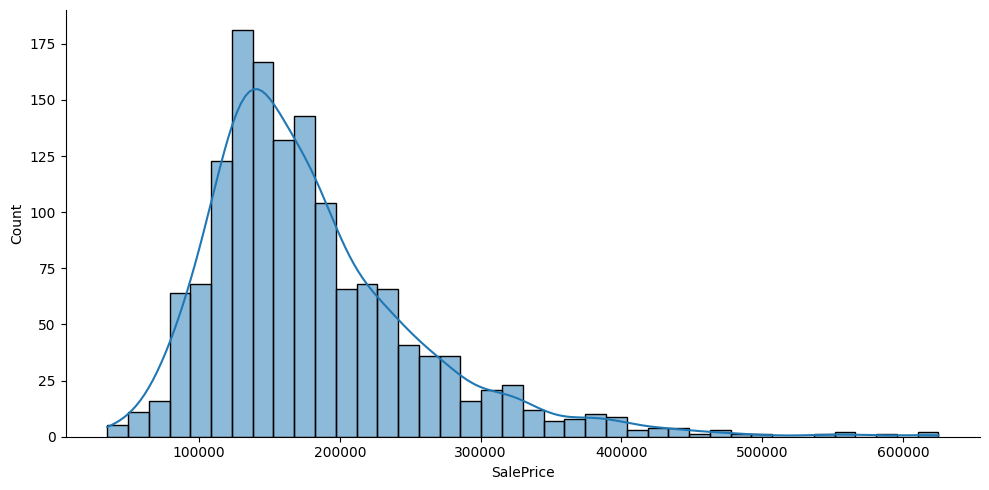

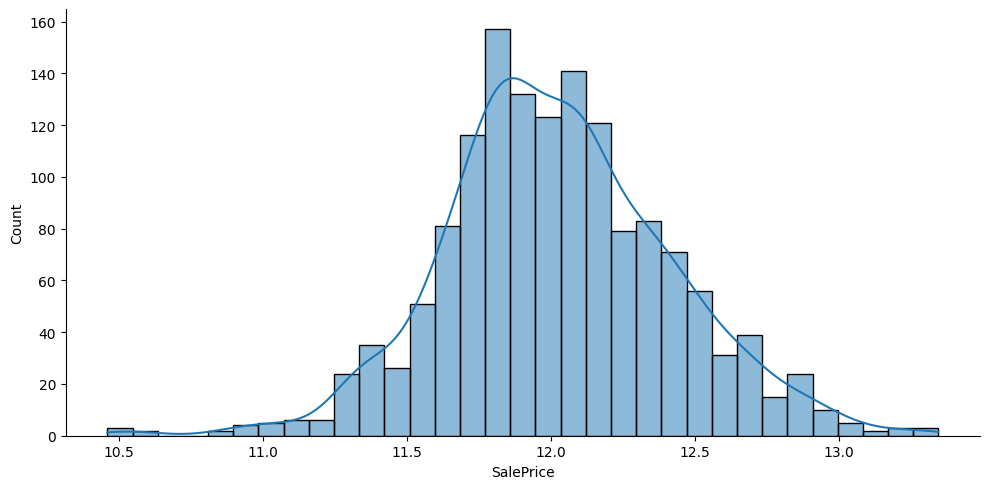

In [26]:
sns.displot(data=y, kde=True, height=5, aspect=2)
sns.displot(data=np.log1p(y), kde=True, height=5, aspect=2)

In [27]:
ridge_reg_log = TransformedTargetRegressor(
    regressor=Ridge(alpha=10, solver="saga"),
    func=np.log1p,
    inverse_func=np.expm1
)
ridge_reg_log = train_evaluate(ridge_reg_log, "Ridge (log)", X_train, y_train, X_test, y_test)

Result for Ridge (log)
RMSE:  19663.04
R2:  0.93
MAE:  14023.44
MAPE:  0.09


Let's check our success using the learning curve

In [28]:
def plot_learning_curves(model, model_name, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_rmse = -train_scores.mean(axis=1)
    test_rmse = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse, "r-+", linewidth=2, label="Train")
    plt.plot(train_sizes, test_rmse, "b-", linewidth=3, label="Val")

    plt.title(f"Learning Curves for {model_name}")
    plt.xlabel("Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

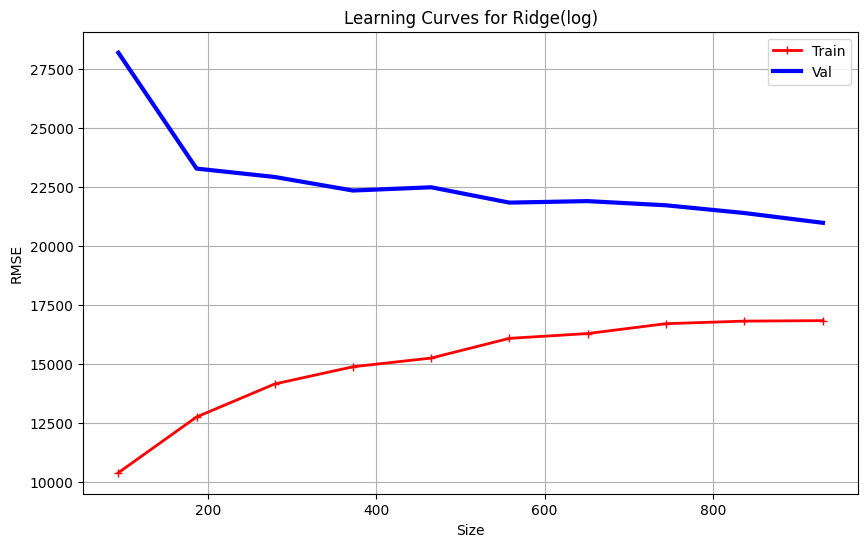

In [29]:
plot_learning_curves(ridge_reg_log, "Ridge(log)", X_train, y_train)

The curves stabilized after 800 samples. A gap of 4000 is not bad for this dataset, and the model has good generalization ability

## Regression SVM

### LinearSVR

In [30]:
lin_svr = LinearSVR(epsilon=1, C=10000)
lin_svr = train_evaluate(lin_svr, "LinearSVR", X_train, y_train, X_test, y_test)

Result for LinearSVR
RMSE:  21147.14
R2:  0.91
MAE:  14987.73
MAPE:  0.09


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


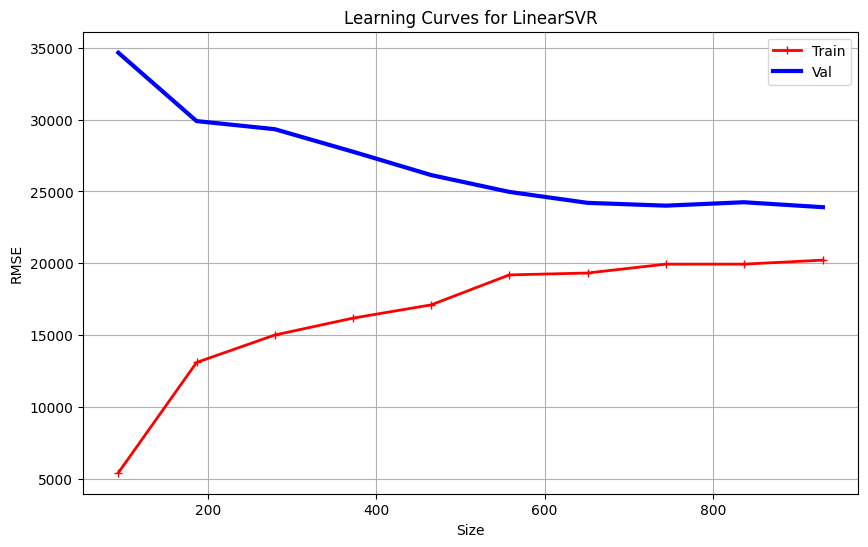

In [31]:
plot_learning_curves(lin_svr, "LinearSVR", X_train, y_train)

The graph with LinearSVR shows a similar pattern to Ridge(log). A gap of 4000 and good generalization ability

Let's find out what happens if we apply logarithmic transformation to LinearSVR

In [32]:
lin_svr_reg_log = TransformedTargetRegressor(
    regressor=LinearSVR(epsilon=0.01, C=1),
    func=np.log1p,
    inverse_func=np.expm1
)
lin_svr_reg_log = train_evaluate(lin_svr_reg_log, "LinearSVR(log)", X_train, y_train, X_test, y_test)

Result for LinearSVR(log)
RMSE:  21399.51
R2:  0.91
MAE:  14489.77
MAPE:  0.09


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The hyperparameters became smaller than without logarithmic scaling, as strong regularization was required before that. After several attempts to tune the hyperparameters, it was not possible to significantly improve the model. Now let's look at the training curve

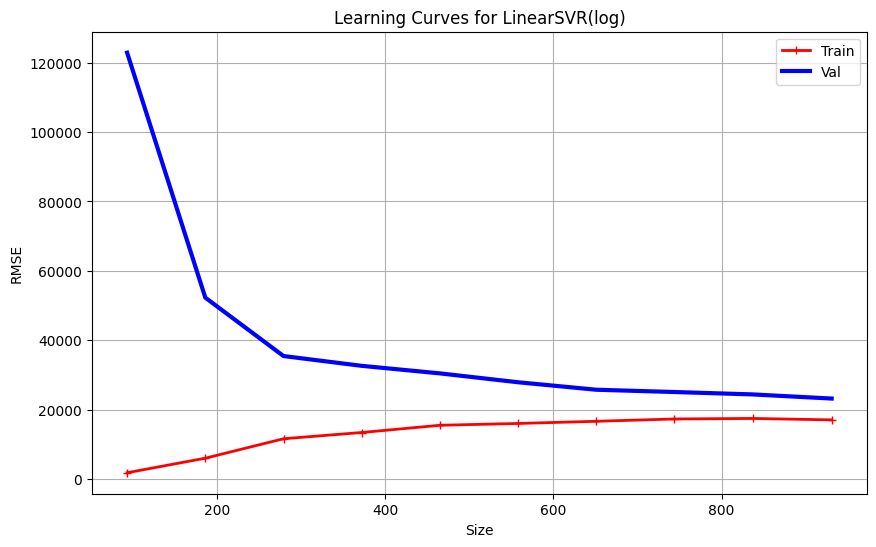

In [33]:
plot_learning_curves(lin_svr_reg_log, "LinearSVR(log)", X_train, y_train)

### Polynomial SVR

In [34]:
poly_svr = SVR(kernel="poly", degree=2, C=100000, epsilon=0.1)
poly_svr = train_evaluate(poly_svr, "Polynomial SVR", X_train, y_train, X_test, y_test)

Result for Polynomial SVR
RMSE:  21140.97
R2:  0.91
MAE:  14607.11
MAPE:  0.09


In [35]:
rbf_svr = SVR(kernel="rbf", C=100000, epsilon=10)
rbf_svr = train_evaluate(rbf_svr, "rbf SVR", X_train, y_train, X_test, y_test)

Result for rbf SVR
RMSE:  21970.83
R2:  0.91
MAE:  14547.03
MAPE:  0.09


# Conclusion

In [36]:
df_res = pd.DataFrame(result)
df_res = df_res.sort_values(by="RMSE", ascending=True)
df_res

,Model,RMSE,R2,MAE,MAPE
7,Ridge (log),19663.04,0.93,14023.44,0.09
10,Polynomial SVR,21140.97,0.91,14607.11,0.09
8,LinearSVR,21147.14,0.91,14987.73,0.09
9,LinearSVR(log),21399.51,0.91,14489.77,0.09
5,ElasticNet,21856.72,0.91,15913.94,0.10
11,rbf SVR,21970.83,0.91,14547.03,0.09
1,SGDRegressor after GridSearch,22056.91,0.91,15940.01,0.10
0,SGDRegressor,22093.21,0.91,15945.99,0.10
3,Ridge,22635.38,0.90,16314.33,0.10
4,Lasso,23068.47,0.90,16380.21,0.10


Let's check how good our model really is

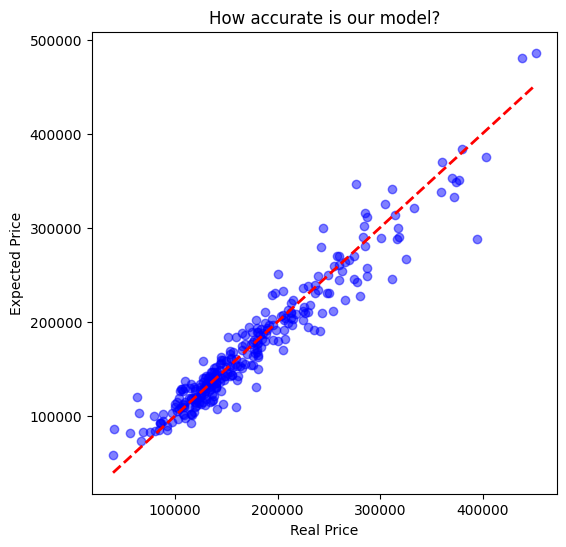

In [37]:
y_pred = ridge_reg_log.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Real Price')
plt.ylabel('Expected Price')
plt.title('How accurate is our model?')
plt.show()

After experimenting with various models, the Ridge(log) achieved the best performance with an RMSE of 19663.

created by me supported by gemini)